In [2]:
from Hamil_search import *
from scipy.sparse.linalg import expm
import matplotlib.pyplot as plt
from math import log2
import sys

In [3]:

def EncodeTar(Htar, blockNum, lamb):
    logDict = {}
    for i in range(blockNum):
        logDict[f'X{2*i}'] = [(-1, f'X{4*i}*X{4*i+2}')]
        logDict[f'X{2*i+1}'] = [(1, f'X{4*i}*X{4*i+1}')]
        logDict[f'Z{2*i}'] = [(1, f'Z{4*i}*Z{4*i+1}')]
        logDict[f'Z{2*i+1}'] = [(1, f'Z{4*i}*Z{4*i+2}')]
        logDict[f'Z{2*i}*Z{2*i+1}'] = [(1, f'Z{4*i+1}*Z{4*i+2}')]
        logDict[f'Z{2*i+1}*Z{2*i+2}'] = [(1, f'Z{4*i+4}*Z{4*i+5}'), ((8*lamb/3)**0.5, f'Z{4*i+1}*X{4*i+6}+Z{4*i+3}*X{4*i+6}')]
    res = []
    for term in Htar:
        after = logDict[term[1]]
        for item in after:
            res.append((item[0]*term[0], item[1]))
    return res

def getU(n, blockNum):
    v1 = ket2Vec(n, ['0001', '-1110'])
    v2 = ket2Vec(n, ['-0010', '1101'])
    v3 = ket2Vec(n, ['0100', '-1011'])
    v4 = ket2Vec(n, ['-0111', '1000'])
    U0 = np.column_stack((v1,v2,v3,v4)) / 2**0.5
    U = U0
    for i in range(blockNum-1):
        U = np.kron(U, U0)
    return U

def getHencBlock(blockNum, lambdaPen):
    Htar_block = getHtarBlock(blockNum)
    Henc_block = EncodeTar(Htar_block, blockNum, lambdaPen)
    return Henc_block

def getHtarBlock(blockNum):
    Htar_block = []
    for i in range(blockNum):
        Htar_block.append((1, f'Z{2*i}*Z{2*i+1}'))
        Htar_block.append((1, f'Z{2*i}'))
        Htar_block.append((1, f'Z{2*i+1}'))
        Htar_block.append((1, f'X{2*i}'))
        Htar_block.append((1, f'X{2*i+1}'))
    for i in range(blockNum-1):
        # B1.append((1, f'Z{2*i+1}*Z{2*i+2}'))
        # B2.append((1, f'Z{2*i+2}'))
        Htar_block.append((1, f'Z{2*i+1}*Z{2*i+2}'))
    return Htar_block

def blockize(block, blockNum, key=4):
    blocks = []
    for i in range(blockNum):
        for b in block:
            pstr = b[1]
            bmap = {}
            for j in range(key):
                bmap[f'{j}'] = f'{key*i+j}'
            for k in bmap.keys():
                pstr=pstr.replace(k, bmap[k])
            blocks.append((b[0], pstr))
    return blocks

def exp_minus_iHt(H, t):
    """
    e^{-iHt}
    """
    e, u = np.linalg.eigh(H)
    e = np.expand_dims(e, axis=1)
    A = u.conj().T
    A = np.exp(-1j*e*t) * A
    A = u @ A
    return A

def exp_minus_iHt_mult_B(H, t, B):
    """
    e^{-iHt} B
    """
    e, u = np.linalg.eigh(H)
    e = np.expand_dims(e, axis=1)
    A = u.conj().T @ B
    A = np.exp(-1j*e*t) * A
    A = u @ A
    return A

def term2Mat(size, term):
    return term[0] * pauliExpr2Mat(size, term[1])
    
def blocks2Mat(size, block):
    return sum([term2Mat(size, b) for b in block])

def getMatrix(lambdaPen, blockNum):
    n = 4
    size = n*blockNum
    Hpen_block = []
    Htar_block = []
    for i in range(blockNum):
        Htar_block.append((1, f'Z{2*i}*Z{2*i+1}'))
        Htar_block.append((1, f'Z{2*i}'))
        Htar_block.append((1, f'Z{2*i+1}'))
        Htar_block.append((1, f'X{2*i}'))
        Htar_block.append((1, f'X{2*i+1}'))
        Hpen_block += [(1, f'X{4*i}*X{4*i+1}'), (3, f'Z{4*i}*Z{4*i+1}'), (1, f'X{4*i+2}*X{4*i+3}'), (3, f'Z{4*i+2}*Z{4*i+3}')]
    # B1 = []
    # B2 = []
    for i in range(blockNum-1):
        # B1.append((1, f'Z{2*i+1}*Z{2*i+2}'))
        # B2.append((1, f'Z{2*i+2}'))
        Htar_block.append((1, f'Z{2*i+1}*Z{2*i+2}'))
    Henc_block = EncodeTar(Htar_block, blockNum, lambdaPen)
    U = getU(n, blockNum)
    # Benc1 = EncodeTar(B1, blockNum, lambdaPen)
    # Benc2 = EncodeTar(B2, blockNum, lambdaPen)
    # HB1 = blocks2Mat(size, Benc1)
    # HB2 = blocks2Mat(size, Benc2)
    
    P = U @ U.conj().T
    # print('U', U.shape)
    # print(checkSame(P@HB1@P, P@HB2@P))
    # Q = np.identity(P.shape[0]) - P
    # print('P', P.shape)
    Henc = blocks2Mat(size, Henc_block)
    Hpen = blocks2Mat(size, Hpen_block)
    Htar = blocks2Mat(size//2, Htar_block)
    # HpenInverse = np.linalg.pinv(Hpen)
    # print('Henc', Henc.shape)
    # print('Hpen', Hpen.shape)
    # # print('Htar', Htar.shape)
    # print(checkSame(P@Hpen, np.zeros(P.shape)))
    # print(checkSame(P@Hpen@Q, np.zeros(P.shape))) 
    # print(checkSame(P@Henc@P - (P@Henc@Q@HpenInverse@Q@Henc@P / lambdaPen), U@Htar@U.conj().T))
    Hsim = lambdaPen * Hpen + Henc
    # np.random.seed(42)
    return Hsim,Htar,U

def getError(t,iters,size,blockNum,Hsim,Htar,U):
    n = 4
    size = n*blockNum
    size_unenc = int(size/2)
    # print(size_unenc)
    values = []
    for i in range(iters):
        epsilons = np.random.uniform(-1,1,size*3)
        V = [PauliTerm(size, f'X{i}', epsilons[i]) for i in range(size)] + [PauliTerm(size, f'Z{i}', epsilons[i+size]) for i in range(size)] + [PauliTerm(size, f'Y{i}', epsilons[i+2*size]) for i in range(size)]
        V = sum([p.value() for p in V])
        Hleft = exp_minus_iHt_mult_B(Hsim + V, t, U)
        Hright = U @ exp_minus_iHt(Htar, t)
        err = np.linalg.norm(Hleft - Hright, ord = 2)
        values.append(err)
    
    values_unenc = []
    for i in range(iters):
        ep = np.random.uniform(-1,1,size_unenc*3)
        V = [PauliTerm(size_unenc, f'X{i}', ep[i]) for i in range(size_unenc)] + [PauliTerm(size_unenc, f'Z{i}', epsilons[i+size_unenc]) for i in range(size_unenc)] + [PauliTerm(size_unenc, f'Y{i}', epsilons[i+2*size_unenc]) for i in range(size_unenc)]
        V = sum([p.value() for p in V])  
        # Hsim,Htar,U = getMatrix(lambdaPen,blockNum)
        Hleft_unenc= exp_minus_iHt(Htar+ V, t)
        Hright_unenc = exp_minus_iHt(Htar, t)
        err_unenc = np.linalg.norm(Hleft_unenc - Hright_unenc, ord = 2)
        values_unenc.append(err_unenc)


    return values,values_unenc


In [4]:
def getError_lam(t,iters,size,blockNum,Hsim,Htar,U):
    n = 4
    size = n*blockNum
    # size_unenc = int(size/2)
    # print(size_unenc)
    values = []
    for i in range(iters):
        epsilons = np.random.uniform(-1,1,size*3)
        V = [PauliTerm(size, f'X{i}', epsilons[i]) for i in range(size)] + [PauliTerm(size, f'Z{i}', epsilons[i+size]) for i in range(size)] + [PauliTerm(size, f'Y{i}', epsilons[i+2*size]) for i in range(size)]
        V = sum([p.value() for p in V])
        Hleft = exp_minus_iHt_mult_B(Hsim + V, t, U)
        Hright = U @ exp_minus_iHt(Htar, t)
        err = np.linalg.norm(Hleft - Hright, ord = 2)
        values.append(err)
    return values


In [ ]:
## 1. add error to Htar(size = 4n, here size = 2n)
## 2. compute the unencoded error (exp(-i(H+V)t) - exp(-iHt))
## 3. data of lambda range and time range

In [ ]:
lambdaPen = 8
blockNum = 2
iters =100
size = 4*blockNum
Hsim,Htar,U = getMatrix(lambdaPen, blockNum)

In [33]:

time_points = np.arange(0, 10.1, 0.1) 
errorl = []
error_unencl = []
for t in time_points:
    error, error_unenc = getError(t,iters,size,blockNum,Hsim,Htar,U)
    errorl.append(error)
    error_unencl.append(error_unenc)
errorl = np.array(errorl)
error_unencl = np.array(error_unencl)


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [52]:
# save the data
np.save('2block_unenc.npy', error_unencl)
np.save('2block_8lam_enc.npy', errorl)

In [53]:
error_unencl = np.load('2block_unenc.npy')
errorl = np.load('2block_8lam_enc.npy')

In [54]:
emean = np.mean(errorl, axis = 1 )
evars = np.var(errorl,axis =1 )
emean_unenc = np.mean(error_unencl, axis =1)
evars_unenc = np.var(error_unencl, axis = 1)

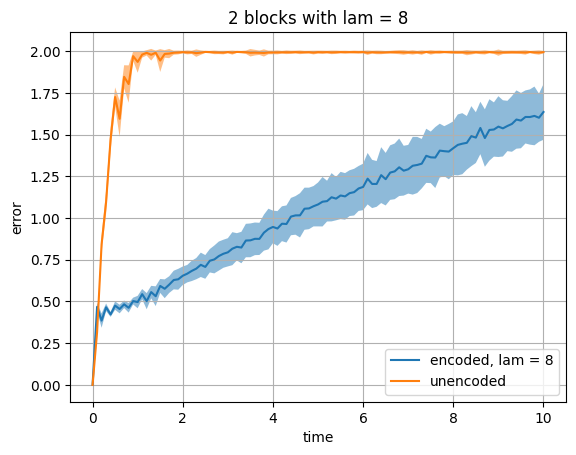

In [55]:
x = time_points
y = emean
std = np.sqrt(evars)
plt.plot(x,y,label = 'encoded, lam = '+str(8))
plt.fill_between(x, y+std, y-std,alpha = 0.5)
y = emean_unenc
std = np.sqrt(evars_unenc)
plt.plot(x,y,label = 'unencoded')
plt.fill_between(x, y+std, y-std,alpha = 0.5)

plt.xlabel('time')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.title('2 blocks with lam = 8')
plt.show()

In [59]:
# more lambdas 
laml = [2**i for i in range(4,11)]
store = []
for lambdaPen in laml:
    blockNum = 2
    iters =100
    size = 4*blockNum
    Hsim,Htar,U = getMatrix(lambdaPen, blockNum)
    time_points = np.arange(0, 10.1, 0.1) 
    errorl = []
    for t in time_points:
        error = getError_lam(t,iters,size,blockNum,Hsim,Htar,U)
        errorl.append(error)
    errorl = np.array(errorl)
    store.append(errorl)

In [64]:
store[1].shape

(101, 100)

In [67]:
laml

[16, 32, 64, 128, 256, 512, 1024]

In [68]:
np.save('2block_lam16tolam1024_enc.npy',store)

In [70]:
emean_list = []
evar_list = []
for i in range(len(store)):
    lam = laml[i]
    emean = np.mean(store[i], axis = 1 )
    evars = np.var(store[i],axis =1 )
    emean_list.append(emean)
    evar_list.append(evars)


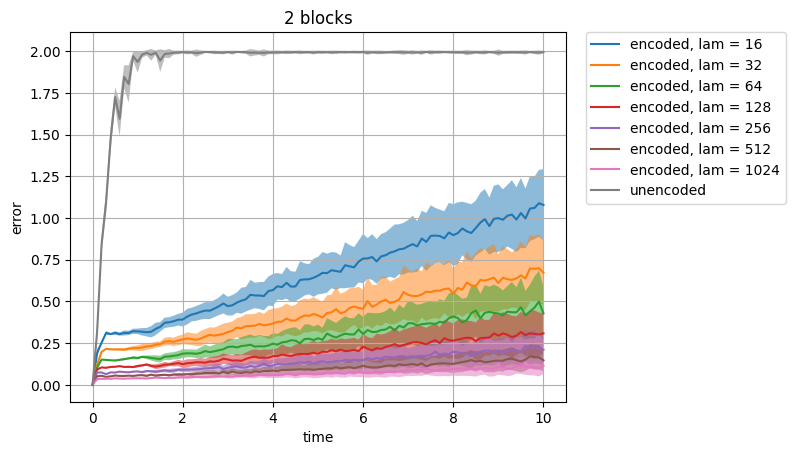

In [78]:
for i in range(len(store)):
    lam = laml[i]
    x = time_points
    y = emean_list[i]
    std = np.sqrt(evar_list[i])
    plt.plot(x,y,label = 'encoded, lam = '+str(lam))
    plt.fill_between(x, y+std, y-std,alpha = 0.5)
y = emean_unenc
std = np.sqrt(evars_unenc)
plt.plot(x,y,label = 'unencoded')
plt.fill_between(x, y+std, y-std,alpha = 0.5)
    

plt.xlabel('time')
plt.ylabel('error')
plt.grid()
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('2 blocks')
plt.show()
    

In [5]:
lambdaPen = 8
blockNum = 1
iters =100
size = 4*blockNum
Hsim,Htar,U = getMatrix(lambdaPen, blockNum)

time_points = np.arange(0, 10.1, 0.1) 
errorl = []
error_unencl = []
for t in time_points:
    error, error_unenc = getError(t,iters,size,blockNum,Hsim,Htar,U)
    errorl.append(error)
    error_unencl.append(error_unenc)
errorl = np.array(errorl)
error_unencl = np.array(error_unencl)

In [9]:
np.save('1block_unenc.npy', error_unencl)
np.save('1block_8lam_enc.npy', errorl)

In [7]:
emean = np.mean(errorl, axis = 1 )
evars = np.var(errorl,axis =1 )
emean_unenc = np.mean(error_unencl, axis =1)
evars_unenc = np.var(error_unencl, axis = 1)

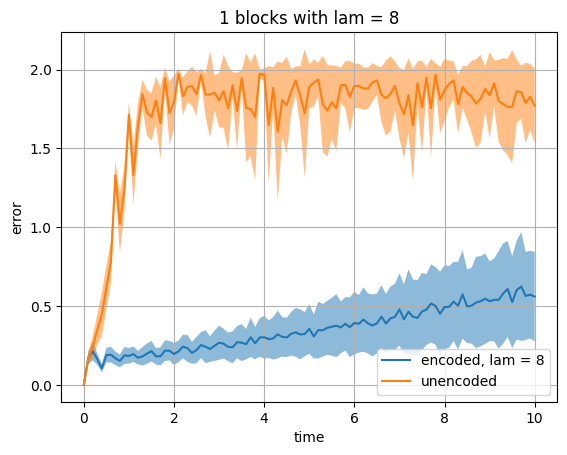

In [8]:
x = time_points
y = emean
std = np.sqrt(evars)
plt.plot(x,y,label = 'encoded, lam = '+str(8))
plt.fill_between(x, y+std, y-std,alpha = 0.5)
y = emean_unenc
std = np.sqrt(evars_unenc)
plt.plot(x,y,label = 'unencoded')
plt.fill_between(x, y+std, y-std,alpha = 0.5)

plt.xlabel('time')
plt.ylabel('error')
plt.grid()
plt.legend()
plt.title('1 blocks with lam = 8')
plt.show()

In [11]:
# more lambdas 
laml = [2**i for i in range(4,11)]
store = []
for lambdaPen in laml:
    blockNum = 1
    iters =100
    size = 4*blockNum
    Hsim,Htar,U = getMatrix(lambdaPen, blockNum)
    time_points = np.arange(0, 10.1, 0.1) 
    errorl = []
    for t in time_points:
        error = getError_lam(t,iters,size,blockNum,Hsim,Htar,U)
        errorl.append(error)
    errorl = np.array(errorl)
    store.append(errorl)

In [13]:
np.save('1block_lam16tolam1024_enc.npy',store)

In [14]:
emean_list = []
evar_list = []
for i in range(len(store)):
    lam = laml[i]
    emean = np.mean(store[i], axis = 1 )
    evars = np.var(store[i],axis =1 )
    emean_list.append(emean)
    evar_list.append(evars)

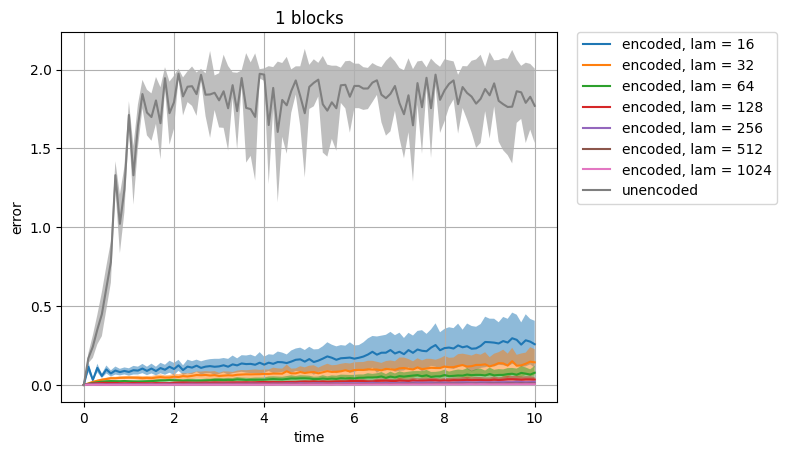

In [16]:
for i in range(len(store)):
    lam = laml[i]
    x = time_points
    y = emean_list[i]
    std = np.sqrt(evar_list[i])
    plt.plot(x,y,label = 'encoded, lam = '+str(lam))
    plt.fill_between(x, y+std, y-std,alpha = 0.5)
y = emean_unenc
std = np.sqrt(evars_unenc)
plt.plot(x,y,label = 'unencoded')
plt.fill_between(x, y+std, y-std,alpha = 0.5)
    

plt.xlabel('time')
plt.ylabel('error')
plt.grid()
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.title('1 blocks')
plt.show()
    